# Анализ A/B теста

Крупный онлайн-магазин проверяет различные гипотезы.  
Мне предстоит приоретизировать гипотезы, используя фреймворки ICE и RICE, а также изучить результаты проведенного A/B теста.  


**Цель анализа:** определить, значимы ли статистически изменения между группами A и B.

**Задачи:**  
1. Провести приоретизацию гипотез
2. Проанализировать кумулятивные графики выручки, среднего чека, отношения средних чеков групп к друг другу  
3. Изучить данные на наличие аномальных значений и очистить их, если аномалии найдутся  
4. Проверить гипотезы о равенстве количества заказов у пользователей и о равенстве средних чеков на сырых и очищенных данных  
5. Принять решение о целесообразности продолжения эксперимента и зафиксировать результаты

Прежде чем приступить к анализу - загружу необходимые мне библиотеки для работы в Python.

In [58]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

Сохраню данные, необходимые для анализа, в переменные:

In [59]:
#Данные о гипотезах
hypothesis = pd.read_csv(r'C:\Users\HOME\Desktop\Practicum\datasets\A_B_tests\hypothesis.csv')

#О заказах
orders = pd.read_csv(r'C:\Users\HOME\Desktop\Practicum\datasets\A_B_tests\orders.csv')
#и о посетителях
visitors = pd.read_csv(r'C:\Users\HOME\Desktop\Practicum\datasets\A_B_tests\visitors.csv')

## Обзор данных и предобработка

### Обзор данных

Начну с данных о гипотезах

In [3]:
hypothesis.head(3)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3


Приведу столбцы к единому стилю с нижним регистром

In [4]:
hypothesis.columns = hypothesis.columns.str.lower()

В данных о гипотезах пять столбцов:  
- `hypothesis` - непосредственно описание гипотезы;
- `reach` - оценка параметра, который показывает охват пользователей, которых затронет реализация гипотезы;
- `impact` - параметр, оценивающий силу влияния изменения метрики на пользователей;
- `confidence` - параметр, показывающий степень уверенности в оценки других параметров;
- `efforts` - параметр, оценивающий сложность исследования гипотезы

Каждый из параметров оценен по 10-и бальной шкале.

Посмотрю также наборы данных с заказами и посетителями в рамках A/B-теста

In [5]:
orders.head(3)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A


In [6]:
visitors.head(3)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507


Столбцы в **orders**:
- `transactionId` — идентификатор заказа;
- `visitorId` — идентификатор пользователя, совершившего заказ;
- `date` — дата, когда был совершён заказ;
- `revenue` — выручка заказа;
- `group` — группа A/B-теста, в которую попал заказ.

Столбцы в **visitors**:
- `date` — дата;
- `group` — группа A/B-теста;
- `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

Столбцы с датой приведу к временному формату.

In [7]:
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

### Проверка на дубликаты и пропуски

Проверю данные на наличие дубликатов:

In [8]:
orders.duplicated(subset=['transactionId', 'visitorId']).sum()

0

В таблице с данными о заказах дубликатов нет.

In [9]:
visitors.duplicated().sum()

0

В таблице с посетителями - тоже.

Посмотрю информацию о датафреймах, чтобы убедиться, что в данных нет пропусков.

In [10]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


In [11]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


В обоих датафреймах нет ни дубликатов, ни пропусков.

### Проверка распределения пользователей на группы

Возможно, в данных есть пользователи, которые по ошибке попали в обе группы. Проверю, есть ли такие пользователи

In [12]:
print('Количество пользователей, которым присвоено больше одной группы:',
     orders[orders['visitorId'].isin(
     orders.groupby('visitorId', as_index=False)
     .agg({'group':'nunique'})
     .query('group > 1')['visitorId'])
           ].agg({'visitorId':'nunique'})
     )

Количество пользователей, которым присвоено больше одной группы: visitorId    58
dtype: int64


Посмотрю также на количество пользователей в каждой из групп по первой присвоенной группе.

In [13]:
orders.groupby('visitorId').agg({'group':'first'}).value_counts()

group
B        556
A        475
dtype: int64

In [14]:
print('Доля пользователей с двумя группами от общего числа пользователей:',
     round((orders.groupby('visitorId', as_index=False)
     .agg({'group':'nunique'})
     .query('group > 1')['visitorId']).count() / orders['visitorId'].nunique(), 3)
     )

Доля пользователей с двумя группами от общего числа пользователей: 0.056


Немного больше 5% пользователей попали сразу в обе группы.  
Работать с такими пользователями можно по-разному: присвоить им ту группу, которая была присвоена изначально, либо присвоить последнюю, либо вовсе сбалансировать количество групп присваивая такую, чтобы добиться примерно равных долей пользователей в каждой из групп, но все это грозит искажением результатов, поскольку я не знаю, как присваивалось значение группы пользователей в таблице заказов.  
Поэтому лучшим вариантом представляется избавиться от всех записей с этими пользователями.

Очищу данные от пользователей, которые попали в две группы сразу:

In [15]:
orders = orders[~orders['visitorId'].isin(orders.groupby('visitorId', as_index=False)
                                          .agg({'group':'nunique'})
                                          .query('group > 1')['visitorId']
                                         )]

Проверю новое распределение по количесту пользователей в группах.

In [16]:
orders.groupby('visitorId').agg({'group':'first'}).value_counts()

group
B        528
A        445
dtype: int64

Распределение осталось примерно таким же.

## Приоритизация гипотез

Для приоритизации гипотез воспользуюсь фреймворками ICE и RICE

In [17]:
hypothesis['ice'] = (hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
hypothesis['ice'] = round(hypothesis['ice'], 2)
hypothesis.sort_values('ice', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ice
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5,16.20
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6,13.33
7,Добавить форму подписки на все основные страни...,10,7,8,5,11.20
6,Показать на главной странице баннеры с актуаль...,5,3,8,3,8.00
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3,7.00
1,"Запустить собственную службу доставки, что сок...",2,5,4,10,2.00
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3,1.33
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8,1.12
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1,1.00


По фреймворку ICE наиболее приоритетными для реализации являются гипотезы под номерами 8, 0 и 7.  
Но если учесть и параметр reach - скорее всего приоритетность изменится.

In [18]:
hypothesis['rice'] = (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
hypothesis['rice'] = round(hypothesis['rice'], 2)
pd.DataFrame(hypothesis[['hypothesis', 'ice', 'rice']]\
             .sort_values('rice', ascending=False))\
             .style.background_gradient('GnBu')\
             .format({'ice': '{0:.2f}', 'rice':'{0:0.2f}'})

,hypothesis,ice,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20,112.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00,56.00
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33,40.00
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00,40.00
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20,16.20
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12,9.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00,4.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33,4.00
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00,3.00


Действительно, с учетом параметра, отвечающего за охват пользователей, в лидеры выбирается гипотеза №7, так как она охватывает всех пользователей.  
В связи с большим охватом пользователей также выбирается в топ гипотеза №2, которая по фреймворку ICE занимала лишь 5-е место.  
Гипотеза №8 утратила высокий приоритет, так как имеет оценку reach в один балл.

Итак, три гипотезы, которые имеют самую высокую приоритетность по RICE звучат следующим образом:

In [19]:
hypothesis.sort_values('rice', ascending=False)['hypothesis'].head(3).values.tolist()

['Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок',
 'Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа',
 'Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей']

## Анализ собранных для A/B-теста данных

### Анализ кумулятивных графиков

При анализе результатов A/B-теста лучше ориентироваться на кумулятивные графики, чтобы было ясно видно, установилось ли четкое среднее измеряемого параметра для каждой из групп теста.

Изучу кумулятивную выручку, средний чек, относительное изменение кумулятивного среднего чека группы B к группе A, а также кумулятивное среднее количества заказов на посетителя.

#### Кумулятивная выручка и средний чек

In [19]:
# Создам массив с набором уникальных дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

# В переменную вложу кумулятивные данные о заказах по дням
ordersAggregated = (datesGroups
                    .apply(lambda x: orders[
                        np.logical_and(orders['date'] <= x['date'],
                                       orders['group'] == x['group'])]
                                 .agg({'date' : 'max',
                                 'group' : 'max',
                                 'transactionId' : 'nunique',
                                 'visitorId' : 'nunique',
                                 'revenue' : 'sum'}), axis=1)
                    .sort_values(by=['date','group']))

# И агрегированные кумулятивные данные о посетителях по дням
visitorsAggregated = (datesGroups
                      .apply(lambda x: visitors[
                          np.logical_and(visitors['date'] <= x['date'],
                                         visitors['group'] == x['group'])]
                             .agg({'date' : 'max',
                                   'group' : 'max',
                                   'visitors' : 'sum'}), axis=1)
                      .sort_values(by=['date','group']))

# Кумулятивные данные объединю в одной таблице
cumulativeData = ordersAggregated.merge(visitorsAggregated,
                                        left_on=['date', 'group'],
                                        right_on=['date', 'group'])

# Переименую столбцы для простоты работы
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeData.head(3)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338


Чтобы построить график - разделю данные о выручке по группам

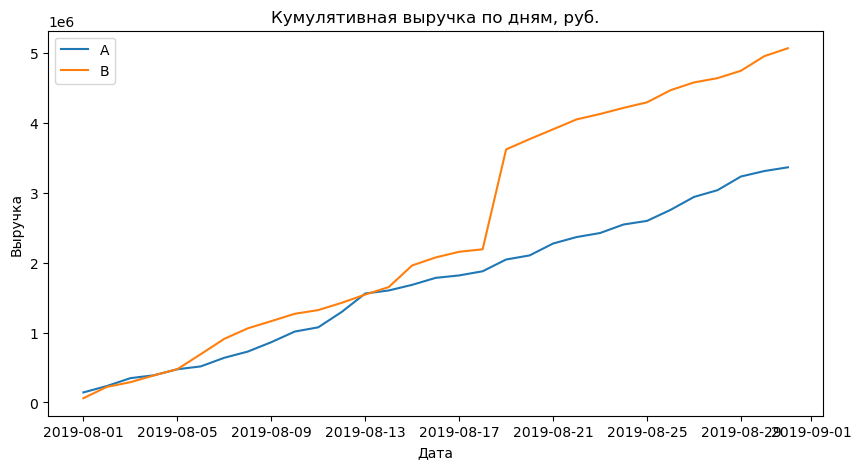

In [20]:
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(10, 5))

# График выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# График выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.title('Кумулятивная выручка по дням, руб.')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.legend();

Группа B почти во все дни обгоняет группу A по выручке. В глаза бросается сильный скачок между 17 и 21 августа. Возможно, тогда случился выброс и кто-то оформил чрезмерно дорогой заказ. Но тем не менее на первый взгляд кажется, что и без него у группы B есть преимущество в выручке.  

Посмотрю также на график среднего чека по группам.

#### Величина среднего чека по группам

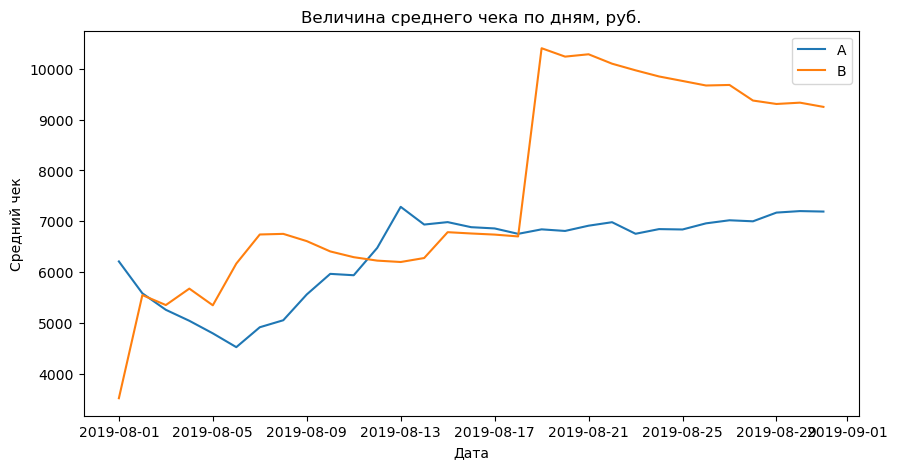

In [21]:
plt.figure(figsize=(10, 5))

# График среднего чека группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
# График среднего чека группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')

plt.title('Величина среднего чека по дням, руб.')
plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.legend();

На графике среднего чека даже отчетливее виден сильный скачок в тот же период (с 19 августа).  
Предположение о том, что его образовал выброс, только укрепляется.

#### Отношение среднего чека группы В к группе А

Для наглядности построю и график отношения среднего чека группы B к группе А.

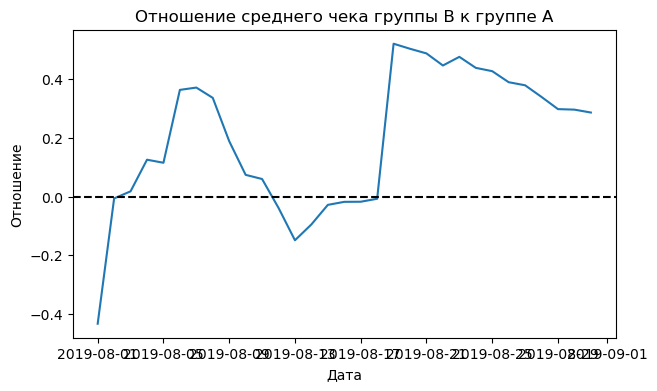

In [25]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB,
                                                   left_on='date',
                                                   right_on='date',
                                                   how='left',
                                                   suffixes=['A', 'B'])

plt.figure(figsize=(7, 4))

plt.plot(mergedCumulativeRevenue['date'],
         (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])
         / (mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)


plt.axhline(y=0, color='black', linestyle='--')

plt.title('Отношение среднего чека группы B к группе А')
plt.xlabel('Дата')
plt.ylabel('Отношение');

В течение эксперемента только около четырех дней средний чек в группе А был выше, чем в группе B.  
Визуально кажется, что у группы B есть преимущество. Но не стоит забывать о возможном выбросе, который образовал преимущество на 50% для группы B.

#### Кумулятивное среднее количество заказов

Посмотрю на график кумулятивного среднего количества заказов на пользователя

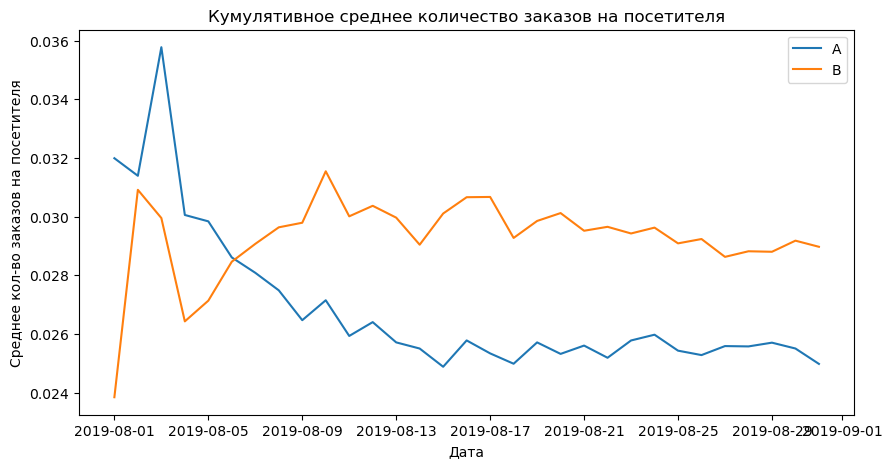

In [26]:
cumulativeOrdersA = cumulativeData[cumulativeData['group']=='A'][['date', 'orders', 'visitors']]
cumulativeOrdersB = cumulativeData[cumulativeData['group']=='B'][['date', 'orders', 'visitors']]

plt.figure(figsize=(10, 5))

plt.plot(cumulativeOrdersA['date'],
         cumulativeOrdersA['orders']/ cumulativeOrdersA['visitors'],
         label='A')

plt.plot(cumulativeOrdersB['date'],
         cumulativeOrdersB['orders']/ cumulativeOrdersB['visitors'],
         label='B')

plt.title('Кумулятивное среднее количество заказов на посетителя')
plt.xlabel('Дата')
plt.ylabel('Среднее кол-во заказов на посетителя')
plt.legend();

Кажется, что группа B лидирует по среднему количеству заказов на пользователя, к тому же и очевидные выбросы на графике в глаза не бросаются.

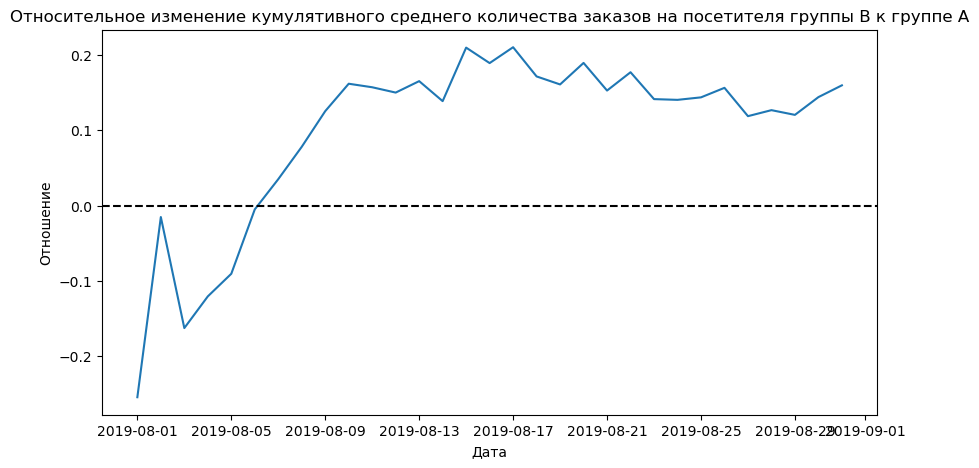

In [27]:
mergedCumulativeOrders = cumulativeOrdersA.merge(cumulativeOrdersB,
                                                   left_on='date',
                                                   right_on='date',
                                                   how='left',
                                                   suffixes=['A', 'B'])

plt.figure(figsize=(10, 5))

plt.plot(mergedCumulativeOrders['date'],
         (mergedCumulativeOrders['ordersB']/mergedCumulativeOrders['visitorsB'])
         / (mergedCumulativeOrders['ordersA']/mergedCumulativeOrders['visitorsA'])-1)


plt.axhline(y=0, color='black', linestyle='--')

plt.title('Относительное изменение кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Отношение');

Группа B имеет преимущество в среднем кол-ве заказов на пользователя в районе 15%.

### Определение аномальных значений

Чтобы тест был достоверным - важно очистить его от выбросов.  
В рамках анализа результатов данного A/B-теста я определю границы аномальных значений для двух показателей: количество заказов на пользователя и стоимость заказа.

#### Определение границы аномальных значений для количества заказов на пользователя

Сначала определю переменную, в которой будет храниться информация о пользователях и количестве их заказов:

In [28]:
ordersByVisitors = (orders.groupby('visitorId', as_index=False)
                    .agg({'transactionId':'nunique'})
                    .sort_values('transactionId', ascending=False)
                   )
ordersByVisitors.columns = ['visitorId', 'orders_amount']
ordersByVisitors.head()

,visitorId,orders_amount
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3


Посмотрю на разброс, используя точечную диаграмму.

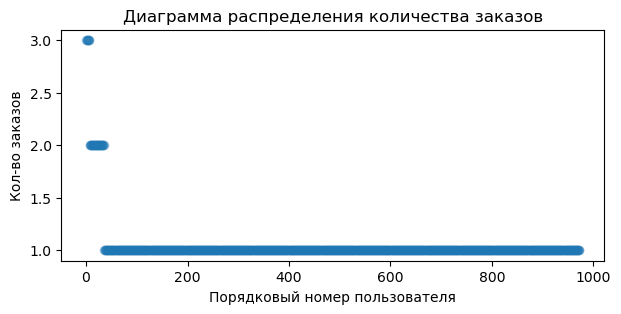

In [32]:
plt.figure(figsize=(7, 3))

plt.scatter(pd.Series(range(0, len(ordersByVisitors))),
            ordersByVisitors['orders_amount'],
            alpha=0.3)

plt.title('Диаграмма распределения количества заказов')
plt.xlabel('Порядковый номер пользователя')
plt.ylabel('Кол-во заказов');

Подавляющее большинство пользователей делают один заказ, и кажется, что выбросами будут являться 2 и более заказа.  
Но вместо того, чтобы определять границу на глаз - воспользуюься процентилями

In [33]:
np.percentile(ordersByVisitors['orders_amount'], [90,95,99])

array([1., 1., 2.])

Не более 1% пользователей совершили два заказа и больше.

In [34]:
print('\033[1m'+'Количество пользователей с n заказов')
pd.DataFrame(ordersByVisitors['orders_amount'].value_counts().sort_index()).style.background_gradient('GnBu')

Количество пользователей с n заказов


,orders_amount
1,937
2,29
3,7


В качестве границы установлю количество заказов менее 2, так как это статистический выброс.

#### Определение границы аномальных значений для стоимости заказа

Аналогично с количеством заказов - сначала посмотрю на точечную диаграмму, и затем посчитаю процентили.

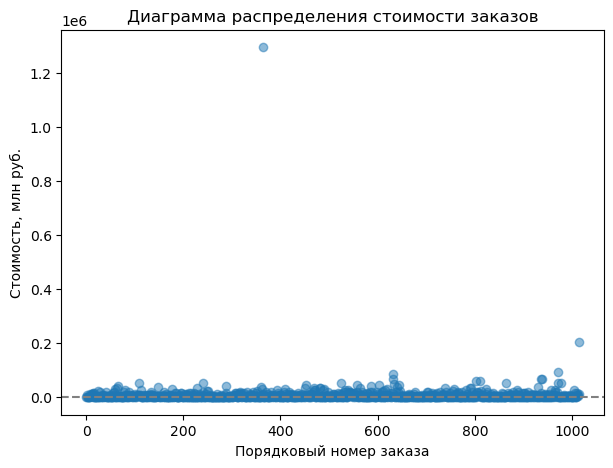

In [37]:
plt.figure(figsize=(7, 5))

plt.scatter(pd.Series(range(0, len(orders))),
            orders['revenue'],
            alpha=0.5)

plt.axhline(y=0.1, color='grey', linestyle='--')
plt.title('Диаграмма распределения стоимости заказов')
plt.xlabel('Порядковый номер заказа')
plt.ylabel('Стоимость, млн руб.');

Заметно, что большинство заказов располагается в районе до ~~100~~ 50 тысяч, но присутствуют и заказы за 200 тыс. и более чем за 1.2 млн.

In [38]:
np.percentile(orders['revenue'], [90,95,99])

array([17990., 26785., 53904.])

В данном случае, как и с числом заказов приму за аномальные значения заказы, сумма которых составляет в общей доле 1%.

Так, **аномальными будут считаться** пользователи, совершившие 4 и более заказов, и заказы с суммой равной ~~58 233~~ 53 904 руб. и более.

### Вывод предварительного анализа

По графику кумулятивной выручки группа B обгоняла группу A начиная со второго дня эксперимента и до его завершения.  
Но на графике 18 августа заметен сильный скачок у группы B, который вероятно вызван присутствием выбросов в данных.  

Средний чек у группы B также обычно выше, чем у группы А. У группы В наблюдается такой же сильный скачок 18 августа от 7 тыс. до 10 тыс. руб.  
Отношение среднего чека группы B к группе A показывает преимущество у группы B.

В связи с проведенным анализом выбросов решено определить аномальные значения для количества заказов на пользователя равным 2 и более, а сумму заказа равную 53 904 руб. и более.

## Анализ статистической значимости различий

Теперь, когда был проведен обзор данных и были определены аномальные значения - можно приступить к выявлению статистической значимости.  
Проверю гипотезы о разности количества заказов на пользователя и о разности среднего чека.  
Проведу тест как для сырых, так и для очищенных данных.

### Статистический анализ сырых данных

#### Гипотеза о количестве заказов на пользователя

Прежде чем приступить к тесту - необходимо подготовить данные.  
Дла каждой из групп теста определю даты и количество пользователей, взаимодействовавших с сервисом в эти даты.

In [39]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg({'date': 'max',
                                                                       'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg({'date': 'max',
                                                                       'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

А также для каждой из групп посчитаю кумулятивную стоимость заказов.

In [40]:
ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

Все переменные объединю в одну

In [41]:
stat_data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

stat_data.head(3)

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803


Определю данные для проверки гипотезы в переменные `sample`, в которых будет информация о количестве заказов каждого пользователя.  
И проверю гипотезу с помощью критерия Манна-Уитни.

*Нулевая гипотеза:* среднее количество заказов пользователей из разных групп не отличается.  
*Альтернативная гипотеза:* среднее количество заказов пользователей из разных групп отличается.

In [42]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

# В sample войдет численность заказов пользователей, в том числе и нули,
# если пользователь не делал заказов
sampleA = pd.concat(
    [ordersByUsersA['orders'],
        pd.Series(0, index=np.arange(
                stat_data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),
            name='orders',),],
    axis=0,
)

sampleB = pd.concat(
    [ordersByUsersB['orders'],
        pd.Series(0, index=np.arange(
                stat_data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),
            name='orders',),],
    axis=0,
)

print('Тест Манна-Уитни. P-value:',
      "{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print('Отношение средних кол-в заказов группы B к A:',
      "{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

Тест Манна-Уитни. P-value: 0.011
Отношение средних кол-в заказов группы B к A: 0.160


Если принять уровень значимости (альфа) за 0.05, то получается, что  
p-value меньше альфа, то есть есть основания отвергнуть нулевую гипотезу о равенстве средних.  
Значит, по сырым данным можно судить, что среднее количество заказов на пользователя в группах отличается, и отношение средних свидетельствует о том, что в группе B пользователи совершают на 16% больше заказов.

#### Гипотеза о  средних чеках

Снова проверю гипотезу с помощью критерия Манна-Уитни.

*Нулевая гипотеза:* средние чеки в группах не отличаются.  
*Альтернативная гипотеза:* средние чеки в группах отличаются.

In [43]:
print('Тест Манна-Уитни. P-value:',
      '{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'],
                                          orders[orders['group']=='B']['revenue'])[1]))
print('Отношение среднего чека группы В к группе А:',
      '{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean() /
                       orders[orders['group']=='A']['revenue'].mean()-1))

Тест Манна-Уитни. P-value: 0.829
Отношение среднего чека группы В к группе А: 0.287


При уровне значимости 0.05 p-value больше, оснований отвергнуть нулевую гипотезу нет.  
Несмотря на то, что средний чек группы В на 28.7% больше, все равно высокое p-value подтверждает гипотезу о том, что они почти не отличаются.

### Статистический анализ очищенных данных

Сначала очищу данные, учитывая границы, определенные раннее.  
Количество заказов пользователя должно быть меньше 4, а сумма заказа менее 58 233 руб.

Найду всех аномальных пользователей и исключу их из сэмплов для проверки гипотезы.

In [44]:
usersWithManyOrders = pd.concat(
    [ordersByUsersA[ordersByUsersA['orders'] >= np.percentile(ordersByVisitors['orders_amount'], 99)]['userId'],
     ordersByUsersB[ordersByUsersB['orders'] >= np.percentile(ordersByVisitors['orders_amount'], 99)]['userId'],],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] >= np.percentile(orders['revenue'], 99)]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

print('Кол-во аномальных пользователей:', abnormalUsers.shape[0])

Кол-во аномальных пользователей: 48


In [45]:
sampleAFiltered = pd.concat(
    [ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(0,
            index=np.arange(
                stat_data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(0,
            index=np.arange(
                stat_data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

#### Гипотеза о количестве заказов на пользователя

*Нулевая гипотеза:* среднее количество заказов пользователей из разных групп отличается.  
*Альтернативная гипотеза:* среднее количество заказов пользователей из разных групп отличается.

In [46]:
print('Тест Манна-Уитни. P-value:',
      '{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('Отношение средних кол-в заказов группы B к A:',
      '{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

Тест Манна-Уитни. P-value: 0.007
Отношение средних кол-в заказов группы B к A: 0.191


Результаты теста не сильно изменились после фильтрации данных.  
Кажется, что в группе В действительно делают немного больше заказов.  
По очищенным данным гипотеза о равенстве количества заказов тоже отвергается.

#### Гипотеза о средних чеках

*Нулевая гипотеза:* средние чеки в группах не отличаются.  
*Альтернативная гипотеза:* средние чеки в группах отличаются.

In [47]:
print('Тест Манна-Уитни. P-value:',
    '{0:.3f}'.format(
        stats.mannwhitneyu(orders[np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )]['revenue'],
            orders[np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )]['revenue'],
        )[1]
    )
)

print('Отношение среднего чека группы B к группе A:',
    "{0:.3f}".format(orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

Тест Манна-Уитни. P-value: 0.973
Отношение среднего чека группы B к группе A: 0.024


После очищения выбросов уверенность в результатах теста только выросла.  
P-value увеличилось, что убеждает в том, что статистической разницы между средними чеками двух групп нет, и она была обусловлена выбросами.  
И даже отношение средних чеков групп уменьшилось и близко к нулю.  
Нулевую гипотезу о равенстве средних чеков двух групп принимаем.

#### Графики после очищения выбросов

Чтобы визуализировать результаты теста - построю график кумулятивной выручки и среднего чека после очищения данных о выбросах.

In [48]:
ordersAggregatedClean = (datesGroups
                        .apply(lambda x: orders[np.logical_not(orders['visitorId'].isin(abnormalUsers))][
                                       np.logical_and(
                                           orders[
                                               np.logical_not(orders['visitorId'].isin(abnormalUsers))
                                           ]['date'] <= x['date'],
                                       orders[
                                           np.logical_not(orders['visitorId'].isin(abnormalUsers))
                                       ]['group'] == x['group'])]
                                 .agg({'date' : 'max',
                                 'group' : 'max',
                                 'transactionId' : 'nunique',
                                 'visitorId' : 'nunique',
                                 'revenue' : 'sum'}), axis=1)
                    .sort_values(by=['date','group']))

visitorsAggregatedClean = (datesGroups
                      .apply(lambda x: visitors[
                          np.logical_and(visitors['date'] <= x['date'],
                                         visitors['group'] == x['group'])]
                             .agg({'date' : 'max',
                                   'group' : 'max',
                                   'visitors' : 'sum'}), axis=1)
                      .sort_values(by=['date','group']))

# Кумулятивные данные объединю в одной таблице
cumulativeDataClean = ordersAggregatedClean.merge(visitorsAggregatedClean,
                                        left_on=['date', 'group'],
                                        right_on=['date', 'group'])

# Переименую столбцы для простоты работы
cumulativeDataClean.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

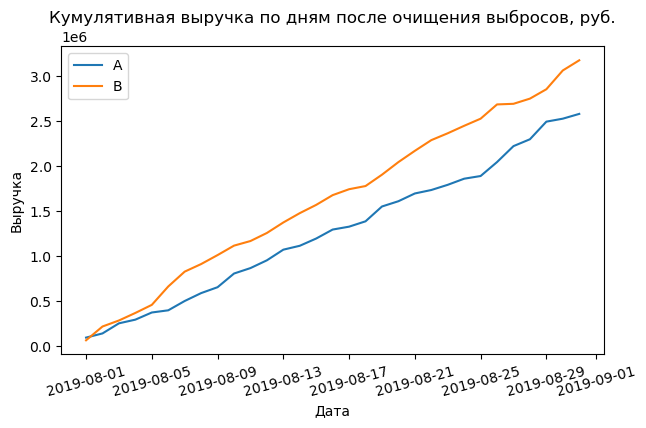

In [55]:
cumulativeRevenueA = cumulativeDataClean[cumulativeDataClean['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeDataClean[cumulativeDataClean['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(7, 4))

# График выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
# График выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.title('Кумулятивная выручка по дням после очищения выбросов, руб.')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.xticks(rotation=15, ha='center')
plt.legend();

Скачок группы В в кумулятивной выручке действительно был связан с выбросом, после очищения видно, что кумулятивная выручка в группе В хотя и выше, чем в группе А, но статистически это не влияет на существенную разницу в среднем чеке.

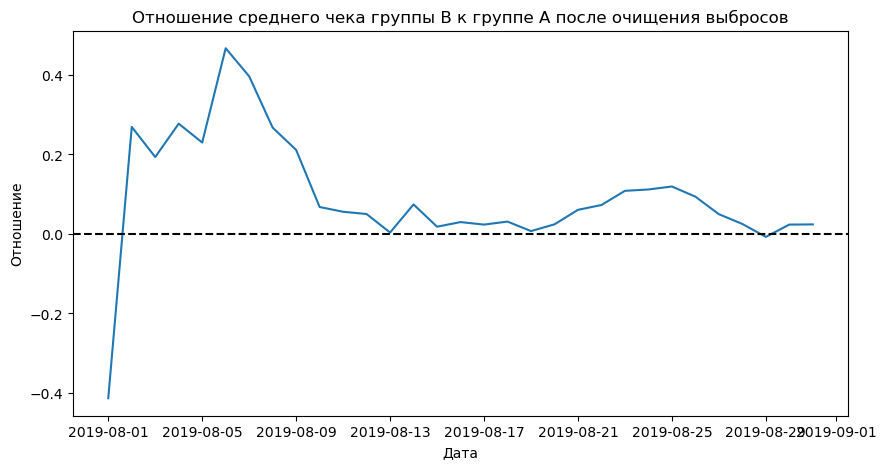

In [56]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB,
                                                   left_on='date',
                                                   right_on='date',
                                                   how='left',
                                                   suffixes=['A', 'B'])

plt.figure(figsize=(10, 5))

plt.plot(mergedCumulativeRevenue['date'],
         (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])
         / (mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)


plt.axhline(y=0, color='black', linestyle='--')

plt.title('Отношение среднего чека группы B к группе А после очищения выбросов')
plt.xlabel('Дата')
plt.ylabel('Отношение');

Средний чек группы В примерно равен среднему чеку группы А и к концу исследования даже ниже.

Осталось посмотреть на график отношения количества заказов группы В к группе А

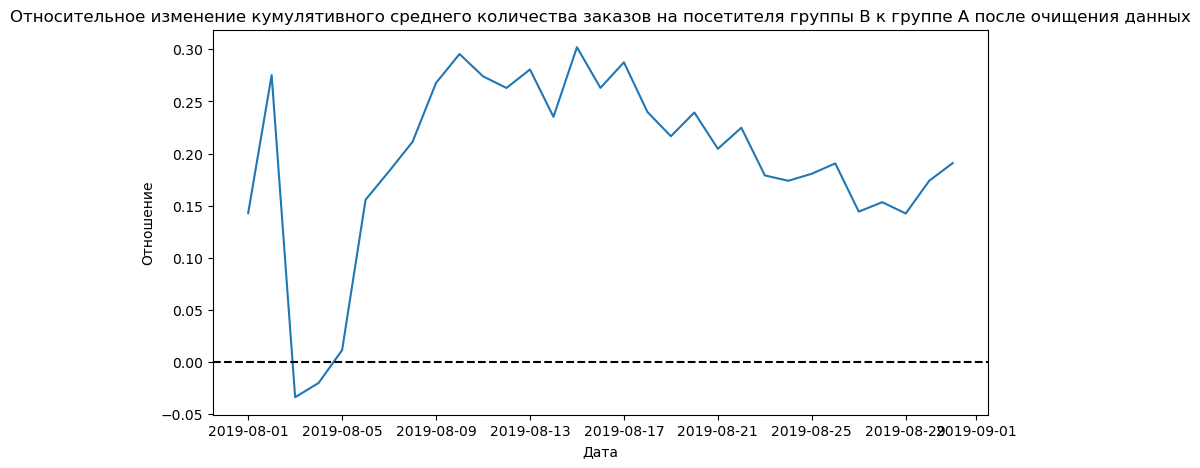

In [57]:
cumulativeOrdersA = cumulativeDataClean[cumulativeDataClean['group']=='A'][['date', 'orders', 'visitors']]
cumulativeOrdersB = cumulativeDataClean[cumulativeDataClean['group']=='B'][['date', 'orders', 'visitors']]
mergedCumulativeOrders = cumulativeOrdersA.merge(cumulativeOrdersB,
                                                   left_on='date',
                                                   right_on='date',
                                                   how='left',
                                                   suffixes=['A', 'B'])

plt.figure(figsize=(10, 5))

plt.plot(mergedCumulativeOrders['date'],
         (mergedCumulativeOrders['ordersB']/mergedCumulativeOrders['visitorsB'])
         / (mergedCumulativeOrders['ordersA']/mergedCumulativeOrders['visitorsA'])-1)


plt.axhline(y=0, color='black', linestyle='--')

plt.title('Относительное изменение кумулятивного среднего \
количества заказов на посетителя группы B к группе A после очищения данных')
plt.xlabel('Дата')
plt.ylabel('Отношение');

Еще при проверке гипотез было видно, что очищенные данные дают больше уверенности в результатах гипотез, проверенных на сырых данных, так и график показывает большую увереннось в преимуществе группы B в числе заказов.

### Вывод анализа статистической значимости различий в группах

До очистки данных от выбросов гипотеза о равенстве кол-ва заказов у пользователей в разных группах была отвергнута.  
А гипотеза о равенстве средних чеков подтверждена.  

Результаты гипотез не изменились и после очистки данных от выбросов, p-value в обеих гипотезах только окрепли в подвтерждение ранее выявленных результатов.  

Графики после очищения выбросов свидетельствуют о том, что экспериемент не стоит продолжать, значения установились на необходимом уровне и позволяют уверенно говорить о результатах.

## Вывод

**Приоритизация гипотез**  
Для приоритизации гипотез были применены фреймворки ICE и RICE, так как RICE учитывает больше факторов - лучше опираться на него для выбора гипотез для дальнейшей проверки.  
Топ-3 гипотезы звучат следующим образом:  
1. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок  
2. Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа  
3. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей  

**Анализ кумулятивных графиков данных, собранных для A/B-теста**  
Кумулятивная выручка группы В была немногим выше до 18 августа, когда она резко выросла с 2.5 млн до 4.3 млн.  
Величина среднего чека в начале только устанавливалась, группы А и В сменяли друг друга по лидерству, но к 18 августу в связи с сильным увеличением выручки - средний чек группы В вырос с 7 000 до 10 000, обозначив разрыв между группой В и А по среднему чеку на 50%.  

**Определение аномальных значений**  
Не более 1% пользователей совершили два и более заказа. Для дальнейшей фитрации выбран порог в количестве заказов до 2.  
В стоимости заказов обнаружены весомые аномалии - заказы суммой в 1.2 млн руб. и 0.2 млн руб., оба из которых относятся к группе В. Скорее всего, именно они стали причиной большого скачка кумулятивной выручки у группы В.  
Используя процентили, выяснилось, что не более 1% заказов стоили более 53 904 тысяч. Поэтому принято взять эту сумму как верхнюю допустимую границу для фильтрации данных от выбросов.  

**Анализ гипотез на сырых данных**  
Гипотеза о равенстве количества заказов у пользователей была опровергнута с p-value 0.011, в группе В заказы делали на 16% чаще.  
Гипотеза о равенстве средних чеков была подтверждена с p-value 0.829, несмотря на то, что в группе В до очищения данных от выбросов средний чек был на 28.7% выше.  

**Анализ гипотез на очищенных данных**  
Гипотеза о равенстве количества заказов у пользователей была опровергнута с p-value 0.007, в группе В заказы делали на 24% чаще. 
Гипотеза о равенстве средних чеков была подтверждена с p-value 0.973, а отношение среднего чека группы В к А снизилось до 2.4%.  
Результаты проверки гипотез после очищения данных от выбросов не изменились, но значения, их подтверждающие, только укрепились.   
Эксперимент продолжать не следует, так как за месяц значения установились.  

По проведенному тесту можно заключить, что группы примерно равны по среднему чеку, но группа В приносит большее количество заказов. А при сохранении среднего чека и увеличении числа заказов, группа В будет приносить большую выручку.  
У группы В есть статистическое преимущество, тест можно считать успешным.